In [17]:
import plotly.graph_objects as go
import joblib
import numpy as np
import pandas as pd

from haversine import haversine, Unit, inverse_haversine
from shapely.geometry import Point, LineString

# Run Location Estimator Notebook to Load class/function

In [18]:
%run 2_location_estimator.ipynb

# Geoplotting function

In [19]:
def plot_points(camera1, camera1_fovd, camera2, camera2_fovd, actual, prediction, x_co, y_co):
    
    #draw line from camera1 to prediction point
    fig = go.Figure(go.Scattermapbox(
        mode = "markers+lines",
        lon = [camera1[1], prediction[1]],
        lat = [camera1[0], prediction[0]],
        marker = {'size': 0},
        line=dict(color='#000000'),
        showlegend=False))

    #draw camera 1 point
    fig.add_trace(go.Scattermapbox(
        mode = "markers+lines",
        lon = [camera1[1]],
        lat = [camera1[0]],
        name = 'Camera 1',
        marker = {'size': 10, 'color':'red'}))

    #draw line from camera 2 to prediction point
    fig.add_trace(go.Scattermapbox(
        mode = "markers+lines",
        lon = [camera2[1], prediction[1]],
        lat = [camera2[0], prediction[0]],
        marker = {'size': 0},
        line=dict(color='#000000'),
        showlegend=False))

    #draw camera 2 point
    fig.add_trace(go.Scattermapbox(
        mode = "markers+lines",
        lon = [camera2[1]],
        lat = [camera2[0]],
        name = 'Camera 2',
        marker = {'size': 10, 'color':'red'}))
    
    #draw line from prediction point to camera1_fovd
    fig.add_trace(go.Scattermapbox(
        mode = "markers+lines",
        lon = [prediction[1], camera1_fovd[1]],
        lat = [prediction[0], camera1_fovd[0]],
        marker = {'size': 0},
        line=dict(color='#000000'),
        showlegend=False))
    
    #draw line from prediction point to camera2_fovd
    fig.add_trace(go.Scattermapbox(
        mode = "markers+lines",
        lon = [prediction[1], camera2_fovd[1]],
        lat = [prediction[0], camera2_fovd[0]],
        marker = {'size': 0},
        line=dict(color='#000000'), 
        showlegend=False))
    
    #draw prediction point
    fig.add_trace(go.Scattermapbox(
        mode = "markers+lines",
        lon = [prediction[1]],
        lat = [prediction[0]],
        name = 'Predicted',
        marker = {'size': 10, 'color':'blue'}))
    
    #draw actual point
    fig.add_trace(go.Scattermapbox(
        mode = "markers+lines",
        lon = [actual[1]],
        lat = [actual[0]],
        name = 'Actual',
        marker = {'size': 10, 'color':'orange'}))

    fig.update_layout(
        margin ={'l':0,'t':0,'b':0,'r':0},
        mapbox = {
            'center': {'lon': x_co-0.05, 'lat': y_co+0.05},
            'style': "stamen-terrain",
            'center': {'lon': x_co+0.05, 'lat': y_co-0.05},
            'zoom': 10})
    
    fig.show()

# Load Test Dataset

In [20]:
df = pd.read_csv("../../../data/raw/landmarks_manual.csv")
cam_meta = pd.read_csv("../../../data/processed/camera_metadata_hpwren.csv")
df_intersections = df.loc[df['intersection'] == 1].reset_index(drop=True)
test_lms = set(df_intersections['landmark'])
df_intersections

,landmark,camera_abbrev,direction,lat,long,x_pixel,y_pixel,x_res,y_res,intersection,distance,tile
0,otay resevoir - north tip,om,west,32.628680,-116.926238,2315,1153,3072,2048,1,3.771505,24
1,otay resevoir - north tip,sm,south,32.628680,-116.926238,1410,1250,3072,2048,1,7.584062,22
2,mt laguna water tower,ml,south,32.875975,-116.414988,765,637,2048,1536,1,1.814854,12
3,nucal egg ranch,mg,south,33.072523,-116.776892,1731,1117,3072,2048,1,12.935871,14
4,nucal egg ranch,bm,south,33.072523,-116.776892,1067,1127,3072,2048,1,9.718958,12
5,Palomar Observatory right,hp,west,33.348388,-116.859694,161,693,2048,1536,1,1.626736,9
6,Palomar Observatory right,bh,east,33.348388,-116.859694,1044,1011,3072,2048,1,1.530121,12
7,target - san clemente,sclm,north,33.464032,-117.605505,642,1183,3072,2048,1,3.626504,19
8,target - san clemente,sjh,south,33.464032,-117.605505,1681,1152,3072,2048,1,4.326559,22
9,santa ynez reservoir,dwpgm,south,34.072078,-118.567900,2738,1321,3072,2048,1,1.593063,26


# Perform Triangulation and Plot

otay resevoir - north tip
X: [-116.93433239], Y: [32.63058633]
Distance From Actual:  0.5624415341237923


/Users/hkim/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

/Users/hkim/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



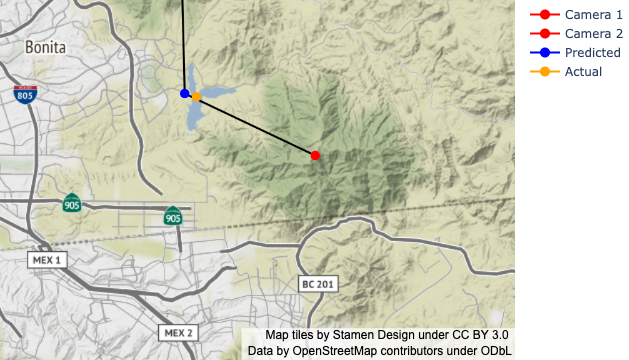

In [21]:
landmark = 'otay resevoir - north tip'
df_test = df_intersections.loc[df_intersections['landmark'] == landmark]
cv1 = camera_view(camera_abbrev=df_test['camera_abbrev'].iloc[0], direction=df_test['direction'].iloc[0], tile_num=df_test['tile'].iloc[0])
cv2 = camera_view(camera_abbrev=df_test['camera_abbrev'].iloc[1], direction=df_test['direction'].iloc[1], tile_num=df_test['tile'].iloc[1])

x_coord = (cv2.y_int - cv1.y_int)/(cv1.slope-cv2.slope)
y_coord = (cv1.slope * x_coord) + cv1.y_int
dist_acc = haversine((df_test['long'].iloc[0],df_test['lat'].iloc[0]), (x_coord, y_coord), unit=Unit.MILES)

print(landmark)
print("X: {}, Y: {}".format(x_coord, y_coord))
print("Distance From Actual: ", dist_acc)

camera1 = (cam_meta['lat'].loc[cam_meta['camera_abbrev'] == cv1.camera_abbrev].iloc[0], cam_meta['long'].loc[cam_meta['camera_abbrev'] == cv1.camera_abbrev].iloc[0])
camera1_fovd = (((x_coord[0])*cv1.slope[0])+cv1.y_int[0], x_coord[0])
camera2 = (cam_meta['lat'].loc[cam_meta['camera_abbrev'] == cv2.camera_abbrev].iloc[0], cam_meta['long'].loc[cam_meta['camera_abbrev'] == cv2.camera_abbrev].iloc[0])
camera2_fovd = (((x_coord[0])*cv2.slope[0])+cv2.y_int[0], x_coord[0])
prediction = (y_coord[0],x_coord[0])
actual = (df_test['lat'].iloc[0],df_test['long'].iloc[0])
plot_points(camera1, camera1_fovd, camera2, camera2_fovd, actual, prediction, x_coord[0], y_coord[0])